In [1]:
# import & logging preliminaries
import logging
import itertools

import gensim
from gensim.parsing.preprocessing import STOPWORDS

logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [2]:
import re 
import string
import unicodedata
import sys

STOPWORDS = [u"ấy", u"bị", u"bởi", u"cả", u"các", u"cái", u"cần", u"càng", u"chỉ", u"chiếc", u"cho", u"chứ", u"chưa", 
             u"chuyện", u"có", u"có_thể", u"cứ", u"của", u"cùng", u"cũng", u"đã", u"đang", u"đây", u"để", u"đến_nỗi", 
             u"đều", u"điều", u"do", u"đó", u"được", u"dưới", u"gì", u"khi", u"không", u"là", u"lại", u"lên", u"lúc", 
             u"mà", u"mỗi", u"một cách", u"này", u"nên", u"nếu", u"ngay", u"nhiều", u"như", u"nhưng", u"những", u"nơi", 
             u"nữa", u"phải", u"qua", u"ra", u"rằng", u"rất", u"rồi", u"sau", u"sẽ", u"so", u"sự", u"tại", u"theo", 
             u"thì", u"trên", u"trước", u"từ", u"từng", u"và", u"vẫn", u"vào", u"vậy", u"vì", u"việc", u"với", u"vừa",
             u"_num", u"wwdateww", u"wwtimeww", u"wwemailww", u"wwipww", u"wwurlww", u"wwnumberww"
            ]

tbl = dict.fromkeys(i for i in xrange(sys.maxunicode)
                      if unicodedata.category(unichr(i)).startswith('P') and i != 45 and i!= 95)

def vi_trans_unicode(su):
    return su.translate(tbl)

def vi_strip_text2(s):
    s = re.sub(r"&amp;", "", s)
    s = vi_trans_unicode(s)
    s = re.sub(r"<([^>]+)>", "", s)
    s = re.sub(r"(\s|\\n|\\r|\\t)+", " ", s)
    s = re.sub(r"__+", "_", s)
    s = re.sub(r"--+", "-", s)
    s = re.sub(r'(.)\1+', r'\1\1', s)
    s = ' '.join([w if not w[0].isdigit() else u"wwNUMBERww" for w in s.strip().split()])
    return s


def vi_clean3(line):
    words = line.replace('.','').strip().split()
    words = [w.lower() for w in words]
    return ' '.join(words)

def vi_remove_stop_1char(line):
    words = line.split()
    words = [w for w in words if w not in STOPWORDS and len(w) > 1]
    return ' '.join(words)

def vi_clean4(line):
    words = line.replace('.','').strip().split()
    words = [w.lower() for w in words if len(w) > 1]
    words = [w for w in words if w not in STOPWORDS]
    return ' '.join(words)

import requests
import codecs
import json

tok_url = "http://192.168.0.215:8081/api/v1.0/document/filter"

def get_tokens(tok_url, data):
    try:
        rq = requests.post(tok_url, data=data.encode('utf-8'))
        if rq.content:
            tok_doc = ' '.join(json.loads(rq.content)['sentences'])
        else:
            tok_doc = None
        return tok_doc
    except Exception, e:
        print e
        

from bs4 import BeautifulSoup

url_post = "http://104.28.2.65:8080/demo/?page=seg_pos_chunk"
header_post = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/4",
    "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8"
}

def tokenize_soup(soup):
    try:
        sentences = soup.findAll('div', {'class': "sentence"})
        toks = [ s.find('tr').findAll('td')[1:] for s in sentences]
        toks = [t.contents[0] for tok in toks for t in tok]
        return ' '.join(toks)
    except Exception, e:
        print e
        
def get_tokens2(INPUT):
    try:
        payload = {r"input":INPUT}
        rsp = requests.post(url_post, data=payload, headers=header_post)
        soup = BeautifulSoup(rsp.content)
        return tokenize_soup(soup)
    except Exception, e:
        print e

## Dictionary, model

In [3]:
from gensim import corpora, models, similarities

In [4]:
# load compact dict
dictionary = corpora.Dictionary.load("/home/laampt/nlp/train/news/lsi/news_180Kdoc.dict")

INFO:gensim.utils:loading Dictionary object from /home/laampt/nlp/train/news/lsi/news_180Kdoc.dict


In [5]:
lsi = models.LsiModel.load("/home/laampt/nlp/train/news/lsi/news_180Kdoc.lsi.mm")

INFO:gensim.utils:loading LsiModel object from /home/laampt/nlp/train/news/lsi/news_180Kdoc.lsi.mm
INFO:gensim.utils:loading id2word recursively from /home/laampt/nlp/train/news/lsi/news_180Kdoc.lsi.mm.id2word.* with mmap=None
INFO:gensim.utils:setting ignored attribute projection to None
INFO:gensim.utils:setting ignored attribute dispatcher to None
INFO:gensim.utils:loading LsiModel object from /home/laampt/nlp/train/news/lsi/news_180Kdoc.lsi.mm.projection
INFO:gensim.utils:loading u from /home/laampt/nlp/train/news/lsi/news_180Kdoc.lsi.mm.projection.u.npy with mmap=None


In [6]:
print lsi

LsiModel(num_terms=392517, num_topics=200, decay=1.0, chunksize=20000)


## Sim index

In [7]:
from gensim.similarities.docsim import Similarity

In [8]:
index_lsi = Similarity.load('/home/laampt/nlp/train/news/lsi/news_180Kdoc_lsi.index')

INFO:gensim.utils:loading Similarity object from /home/laampt/nlp/train/news/lsi/news_180Kdoc_lsi.index


In [9]:
print index_lsi

Similarity index with 189288 documents in 6 shards (stored under shard)


## Doc2vec

In [10]:
import numpy as np  
from gensim.models import Doc2Vec

In [11]:
dmm = Doc2Vec.load("/home/laampt/nlp/train/news/d2v/news_261K_dmm_5ns_200features_2minwords_5context_e5_lowercase_casentok_nostopword_20epo_alpha_r100")
print dmm

INFO:gensim.utils:loading Doc2Vec object from /home/laampt/nlp/train/news/d2v/news_261K_dmm_5ns_200features_2minwords_5context_e5_lowercase_casentok_nostopword_20epo_alpha_r100
INFO:gensim.utils:loading docvecs recursively from /home/laampt/nlp/train/news/d2v/news_261K_dmm_5ns_200features_2minwords_5context_e5_lowercase_casentok_nostopword_20epo_alpha_r100.docvecs.* with mmap=None
INFO:gensim.utils:loading doctag_syn0 from /home/laampt/nlp/train/news/d2v/news_261K_dmm_5ns_200features_2minwords_5context_e5_lowercase_casentok_nostopword_20epo_alpha_r100.docvecs.doctag_syn0.npy with mmap=None
INFO:gensim.utils:loading syn1neg from /home/laampt/nlp/train/news/d2v/news_261K_dmm_5ns_200features_2minwords_5context_e5_lowercase_casentok_nostopword_20epo_alpha_r100.syn1neg.npy with mmap=None
INFO:gensim.utils:loading syn0 from /home/laampt/nlp/train/news/d2v/news_261K_dmm_5ns_200features_2minwords_5context_e5_lowercase_casentok_nostopword_20epo_alpha_r100.syn0.npy with mmap=None
INFO:gensim.uti

Doc2Vec(dm/m,d200,n5,w5,mc2,s1e-05,t8)


In [18]:
print dmm.docvecs.doctag_syn0[1][:10]
print dmm.docvecs[1][:10]

[ 0.11819465  0.02252917 -0.05527491 -0.00620151 -0.05047297  0.14769495
  0.20530233  0.1566548   0.17334339 -0.16159682]
[ 0.11819465  0.02252917 -0.05527491 -0.00620151 -0.05047297  0.14769495
  0.20530233  0.1566548   0.17334339 -0.16159682]


In [30]:
print "Num of docs: ", dmm.docvecs.count
print dmm.docvecs.n_similarity(['SENT_vt_1', 'SENT_vt_2'], ['SENT_vt_100', 'SENT_vt_200'])
dmm.docvecs.trained_item?

Num of docs:  189288
0.61904731227


## Sanity check

In [33]:
# new_doc = u"""tình_hình nhà_mạng vnpt viettel mobifone áp_dụng chính_sách chuyển mạng giữ nguyên số"""
new_doc = u"""Đến nay, Viettel đang thực_hiện đúng lộ_trình thoái vốn mà Thủ_tướng yêu_cầu."""
new_doc = vi_clean4(vi_strip_text2(new_doc))
new_vec = dictionary.doc2bow(new_doc.split())
new_vec_ls = lsi[new_vec]

index_lsi.num_best = 20
related_story_lsi = index_lsi[new_vec_ls]
print related_story_lsi

[(2634, 0.68815743923187256), (13847, 0.68097615242004395), (10904, 0.67659056186676025), (136023, 0.6505778431892395), (118434, 0.64575409889221191), (156469, 0.64530295133590698), (11298, 0.64130252599716187), (55261, 0.63939350843429565), (32957, 0.62919384241104126), (110295, 0.62907785177230835), (37902, 0.62767887115478516), (15176, 0.62761944532394409), (46096, 0.62665653228759766), (125402, 0.62637197971343994), (166477, 0.61827117204666138), (122490, 0.61673116683959961), (43713, 0.61531752347946167), (168015, 0.61521947383880615), (130368, 0.6112787127494812), (159694, 0.61031955480575562)]


In [34]:
new_doc = u"""Đến nay, Viettel đang thực_hiện đúng lộ_trình thoái vốn mà Thủ_tướng yêu_cầu."""
new_doc = vi_clean4(vi_strip_text2(new_doc))
print new_doc
related_story_d2v = []

pos_terms = []
for w in new_doc.split():
    pos_terms.append(dmm[w])

wvec = dmm.infer_vector(new_doc.split())
related_story_d2v = dmm.docvecs.most_similar(positive=pos_terms)
print related_story_d2v

đến nay viettel thực_hiện đúng lộ_trình thoái vốn thủ_tướng yêu_cầu
[(u'SENT_vt_61897', 0.34041744470596313), (u'SENT_vt_97151', 0.34023094177246094), (u'SENT_vt_165543', 0.3342686891555786), (u'SENT_vt_64938', 0.329241544008255), (u'SENT_vt_25220', 0.3268060088157654), (u'SENT_vt_77662', 0.3258041441440582), (u'SENT_vt_134548', 0.3249977231025696), (u'SENT_vt_188529', 0.3120863437652588), (u'SENT_vt_173718', 0.30741631984710693), (u'SENT_vt_149251', 0.30578574538230896)]


## Query

In [35]:
from collections import defaultdict

In [36]:
print new_doc
print '.' * 80
print "[*] Getting seed stories ..."
seeds = []
for s,v in dmm.docvecs.most_similar(positive=pos_terms, topn=20):
    if v > 0.3: seeds.append(s)

seeds = list(set(seeds))

print "[*] Getting depth stories ..."
story_clusters = defaultdict(list)
try:
    seen_seeds = [] # keep seen seends to collapse all near duplicated seeds
    for seed in seeds:
        if seen_seeds:
            max_sim = np.max([dmm.docvecs.similarity(seed,seen) for seen in seen_seeds])
            if max_sim > 0.9:
                continue
                print "PASSED: ", seed
        seen_seeds.append(seed)
        related_stories = [(s,v) for s,v in dmm.docvecs.most_similar([dmm.docvecs[seed]], topn=100) if (v > 0.8) and s != seed]
        story_clusters[seed] = related_stories
        
except Exception, e:
    print e

print len(seeds), len(seen_seeds)

print "NUM SEEDS: {}".format(len(seen_seeds))
print '.' * 80
for seed in seen_seeds:
    related_stories = story_clusters[seed]
    print seed, len(related_stories)
    for story,v in related_stories:
        print "--{}: {}".format(story,v)
    print
    
line_d2v_idx = [int(s.split('_')[-1]) for s in seen_seeds]

đến nay viettel thực_hiện đúng lộ_trình thoái vốn thủ_tướng yêu_cầu
................................................................................
[*] Getting seed stories ...
[*] Getting depth stories ...
19 13
NUM SEEDS: 13
................................................................................
SENT_vt_141747 2
--SENT_vt_134548: 0.935555994511
--SENT_vt_165543: 0.916878759861

SENT_vt_77662 0

SENT_vt_149251 2
--SENT_vt_186162: 0.929334998131
--SENT_vt_92904: 0.889158308506

SENT_vt_188529 1
--SENT_vt_97151: 0.937943816185

SENT_vt_92904 2
--SENT_vt_149251: 0.889158308506
--SENT_vt_186162: 0.886856138706

SENT_vt_25220 0

SENT_vt_137349 7
--SENT_vt_172548: 0.96997231245
--SENT_vt_171865: 0.964117825031
--SENT_vt_65424: 0.963232815266
--SENT_vt_138471: 0.962852120399
--SENT_vt_120381: 0.960778415203
--SENT_vt_138476: 0.954799890518
--SENT_vt_83234: 0.931590437889

SENT_vt_61897 2
--SENT_vt_184361: 0.913268923759
--SENT_vt_110788: 0.903998613358

SENT_vt_173718 0

SENT_vt_11

In [41]:
print new_doc
wvec = dmm.infer_vector(new_doc.split())
print '.' * 80
print "[*] Getting seed stories ..."
seeds = []
for s,v in dmm.docvecs.most_similar(positive=[wvec], topn=100):
    if v > 0.3: seeds.append(s)

seeds = list(set(seeds))

print "[*] Getting depth stories ..."
story_clusters = defaultdict(list)
try:
    seen_seeds = [] # keep seen seends to collapse all near duplicated seeds
    for seed in seeds:
        if seen_seeds:
            max_sim = np.max([dmm.docvecs.similarity(seed,seen) for seen in seen_seeds])
            if max_sim > 0.9:
                continue
                print "PASSED: ", seed
        seen_seeds.append(seed)
        related_stories = [(s,v) for s,v in dmm.docvecs.most_similar([dmm.docvecs[seed]], topn=100) if (v > 0.8) and s != seed]
        story_clusters[seed] = related_stories
        
except Exception, e:
    print e

print len(seeds), len(seen_seeds)

print "NUM SEEDS: {}".format(len(seen_seeds))
print '.' * 80
for seed in seen_seeds:
    related_stories = story_clusters[seed]
    print seed, len(related_stories)
    for story,v in related_stories:
        print "--{}: {}".format(story,v)
    print

đến nay viettel thực_hiện đúng lộ_trình thoái vốn thủ_tướng yêu_cầu
................................................................................
[*] Getting seed stories ...
[*] Getting depth stories ...
100 13
NUM SEEDS: 13
................................................................................
SENT_vt_25325 99
--SENT_vt_158394: 0.949526071548
--SENT_vt_72377: 0.930747210979
--SENT_vt_180345: 0.922453224659
--SENT_vt_108992: 0.916866719723
--SENT_vt_149821: 0.915840089321
--SENT_vt_109135: 0.915203094482
--SENT_vt_29779: 0.910588562489
--SENT_vt_36745: 0.906650602818
--SENT_vt_145105: 0.906282961369
--SENT_vt_109232: 0.905757248402
--SENT_vt_5885: 0.90575248003
--SENT_vt_102976: 0.904366731644
--SENT_vt_26268: 0.903829395771
--SENT_vt_109269: 0.90354937315
--SENT_vt_107079: 0.903420627117
--SENT_vt_144234: 0.902731120586
--SENT_vt_2664: 0.902325510979
--SENT_vt_116179: 0.901966810226
--SENT_vt_144478: 0.901025593281
--SENT_vt_74648: 0.900867640972
--SENT_vt_71698: 0.90020

In [42]:
print seeds
print
print seen_seeds

[u'SENT_vt_25325', u'SENT_vt_69416', u'SENT_vt_72257', u'SENT_vt_4369', u'SENT_vt_37329', u'SENT_vt_71407', u'SENT_vt_51784', u'SENT_vt_95494', u'SENT_vt_109173', u'SENT_vt_126609', u'SENT_vt_12964', u'SENT_vt_57757', u'SENT_vt_95093', u'SENT_vt_175568', u'SENT_vt_51253', u'SENT_vt_5885', u'SENT_vt_108992', u'SENT_vt_102976', u'SENT_vt_58194', u'SENT_vt_130364', u'SENT_vt_5133', u'SENT_vt_30731', u'SENT_vt_127123', u'SENT_vt_117968', u'SENT_vt_116716', u'SENT_vt_98963', u'SENT_vt_14382', u'SENT_vt_104309', u'SENT_vt_91646', u'SENT_vt_91671', u'SENT_vt_46462', u'SENT_vt_48883', u'SENT_vt_142196', u'SENT_vt_61960', u'SENT_vt_4155', u'SENT_vt_163388', u'SENT_vt_35458', u'SENT_vt_181149', u'SENT_vt_159453', u'SENT_vt_108210', u'SENT_vt_40848', u'SENT_vt_109520', u'SENT_vt_107079', u'SENT_vt_17415', u'SENT_vt_10631', u'SENT_vt_2664', u'SENT_vt_4331', u'SENT_vt_155720', u'SENT_vt_116179', u'SENT_vt_113423', u'SENT_vt_175530', u'SENT_vt_125667', u'SENT_vt_109135', u'SENT_vt_107981', u'SENT_vt

## Bulk training check on 1000 docs

In [101]:
rand_idx = np.random.randint(0,180000, 1000)
print len(rand_idx)

1000


In [44]:
test_docs = []
with codecs.open("/home/laampt/nlp/data/news/tok/vt.261K.casen.txt.10word.nodup.clean.nodup", encoding="utf-8", mode='r') as fin:
    for i, line in enumerate(fin):
        if i in rand_idx:
            test_docs.append((i,line))

In [45]:
def get_vec(dmm,doc):
    vec_sum = np.zeros((1,200))
    words = set(doc.split())
    for word in words:
        if word in dmm.vocab:
            vec_sum += dmm[word]
    return vec_sum[0]

In [102]:
slice_tups = []
slice_docs = []
index_lsi.num_best = dmm.docvecs.count

count = 0
for true_id, doc in test_docs:
    if count % 100 == 0: print "[*] PROGRESS at: ", count
    count += 1
    
    doc = doc.split()
    slice_doc = doc[np.random.randint(len(doc)-12):][:500] # get random index from right 12 words, max 300 words
    slice_docs.append(slice_doc)
    slice_inferred = dmm.infer_vector(slice_doc)
    slice_noinferred = get_vec(dmm, ' '.join(slice_doc))
    new_vec = dictionary.doc2bow(slice_doc)
    new_vec_ls = lsi[new_vec]
    
    
    similars = dmm.docvecs.most_similar(positive=[slice_inferred],topn=dmm.docvecs.count)
    similars2 = dmm.docvecs.most_similar(positive=[slice_noinferred],topn=dmm.docvecs.count)
    similars3 = index_lsi[new_vec_ls]
    
    rank_of_source = [int(sim_id.split('_')[-1]) for sim_id, sim in similars].index(true_id)
    rank_of_source2 = [int(sim_id.split('_')[-1]) for sim_id, sim in similars2].index(true_id)
    rank_of_source3 = [int(sim_id) for sim_id, sim in similars3].index(true_id)
    
    slice_tups.append((true_id, len(slice_doc), rank_of_source, rank_of_source2, rank_of_source3))

[*] PROGRESS at:  0
[*] PROGRESS at:  100
[*] PROGRESS at:  200
[*] PROGRESS at:  300
[*] PROGRESS at:  400
[*] PROGRESS at:  500
[*] PROGRESS at:  600
[*] PROGRESS at:  700
[*] PROGRESS at:  800
[*] PROGRESS at:  900


In [103]:
with codecs.open("/home/laampt/nlp/data/news/tok/vt.random_1Kdocs_500words.nodup", encoding="utf-8", mode='w') as fout:
    for doc in slice_docs:
        fout.write(' '.join(doc) + '\n')

## Analyse result

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight') # Good looking plots
pd.set_option('display.max_columns', None) # Display any number of columns

In [105]:
df = pd.DataFrame(slice_tups, columns=['DocID', 'Len', 'DMM', 'SUM', 'LSI'])

In [106]:
df.set_index('DocID', inplace=True)

In [107]:
df.head()

,Len,DMM,SUM,LSI
DocID,,,,
24,60,21,28419,0
147,50,44,13374,0
235,186,8,301,13
269,14,47,537,0
328,22,6438,5224,3


In [108]:
df.describe()

,Len,DMM,SUM,LSI
count,997.000000,997.000000,997.00000,997.00000
mean,171.922768,3403.088265,4114.65998,215.64995
std,143.341075,13378.074053,15601.28746,1884.80743
min,13.000000,0.000000,0.00000,0.00000
25%,57.000000,0.000000,51.00000,0.00000
50%,125.000000,2.000000,287.00000,1.00000
75%,243.000000,56.000000,1910.00000,6.00000
max,500.000000,171506.000000,185093.00000,47561.00000


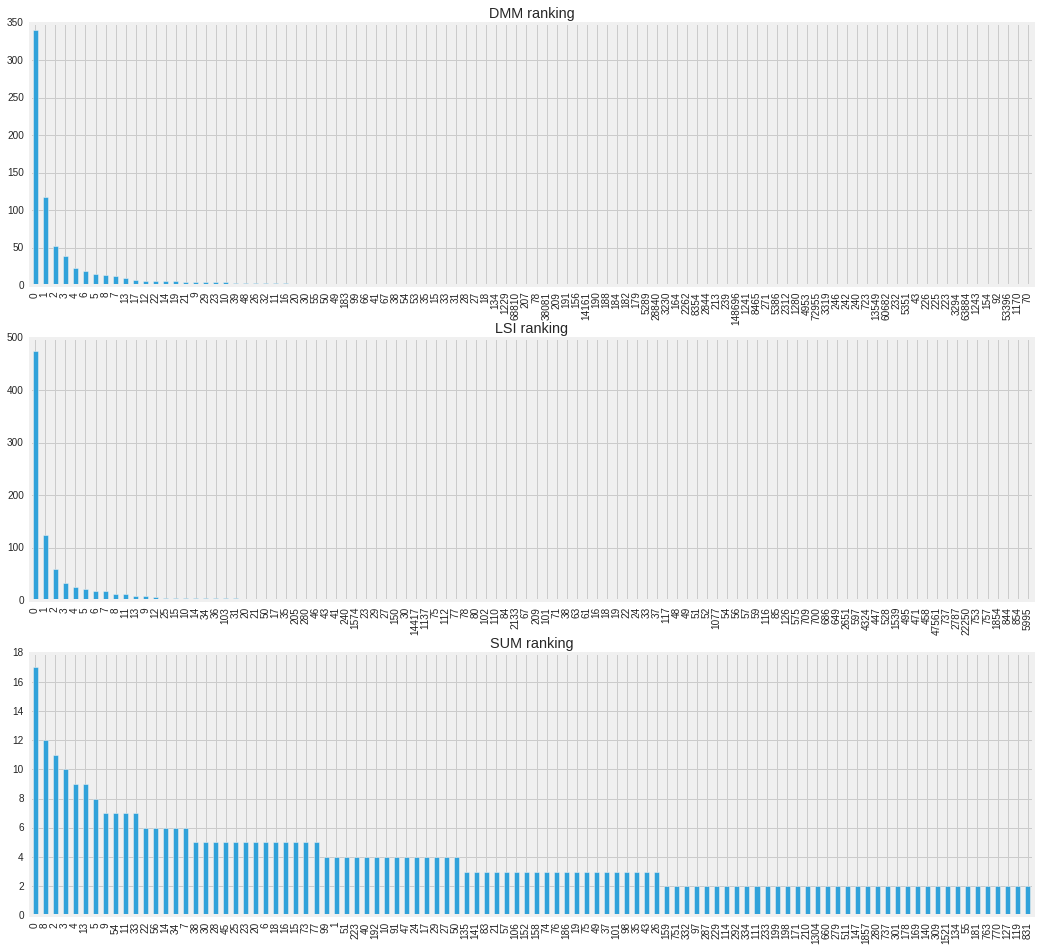

In [109]:
%matplotlib inline 

plt.figure(figsize=(16,16))
plt.subplot(311)
ax1 = df['DMM'].value_counts().head(100).plot(kind='bar', label='DMM')
ax1.set_title("DMM ranking")
plt.subplot(312)
ax2 = df.LSI.value_counts().head(100).plot(kind='bar', label='LSI')
ax2.set_title("LSI ranking")

plt.subplot(313)
ax3 = df.SUM.value_counts().head(100).plot(kind='bar', label='SUM')
ax3.set_title("SUM ranking")
plt.show()

In [110]:
dlm = df.groupby(by=['DMM', 'LSI']).agg({'Len': pd.Series.count})
dlm.rename(columns={'Len': 'Occurrences'}, inplace=True)
dlm.head()

Occurrences
DMM LSI             
0   0            263
    1             33
    2             14
    3              4
    4              2

In [111]:
dlm.reset_index(inplace=True)
dlm.head()

,DMM,LSI,Occurrences
0,0,0,263
1,0,1,33
2,0,2,14
3,0,3,4
4,0,4,2


In [112]:
dlm_pivot = dlm.pivot('DMM', 'LSI', 'Occurrences')
dlm_pivot.fillna(0, inplace=True)
dlm_pivot.head()

LSI,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,29,30,31,33,34,35,36,37,38,41,43,46,48,49,50,51,52,53,54,56,57,59,61,63,67,71,75,77,78,80,84,85,100,101,102,103,110,112,116,117,126,133,135,142,147,150,154,189,191,205,209,211,235,240,244,246,252,256,266,270,280,297,315,351,362,429,447,458,471,495,528,575,597,649,686,700,709,737,753,757,844,854,1001,1077,1127,1137,1233,1309,1367,1404,1539,1574,1854,1913,2133,2175,2201,2255,2471,2485,2651,2787,2929,3010,3472,3485,4280,4324,5176,5273,5995,9669,10070,13192,14417,22250,47561
DMM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,263,33,14,4,2,2,2,3,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,57,32,11,3,1,2,1,0,1,1,1,0,0,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,19,10,6,5,3,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,9,6,4,3,2,3,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,7,6,1,3,2,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


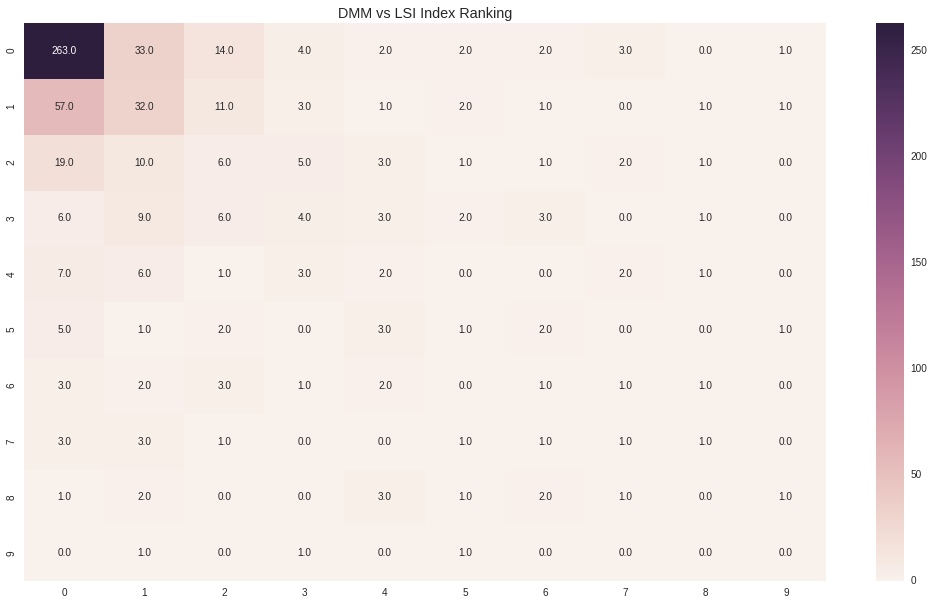

In [114]:
slice_noinferred = get_vec(dmm, ' '.join(slice_doc))
new_vec = dictionary.doc2bow(slice_doc)
new_vec_ls = lsi[new_vec]
plt.figure(figsize=(16, 10))
plt.title('DMM vs LSI Index Ranking')
sns.heatmap(dlm_pivot.as_matrix()[:10,:10], annot=True, fmt='')
plt.show()

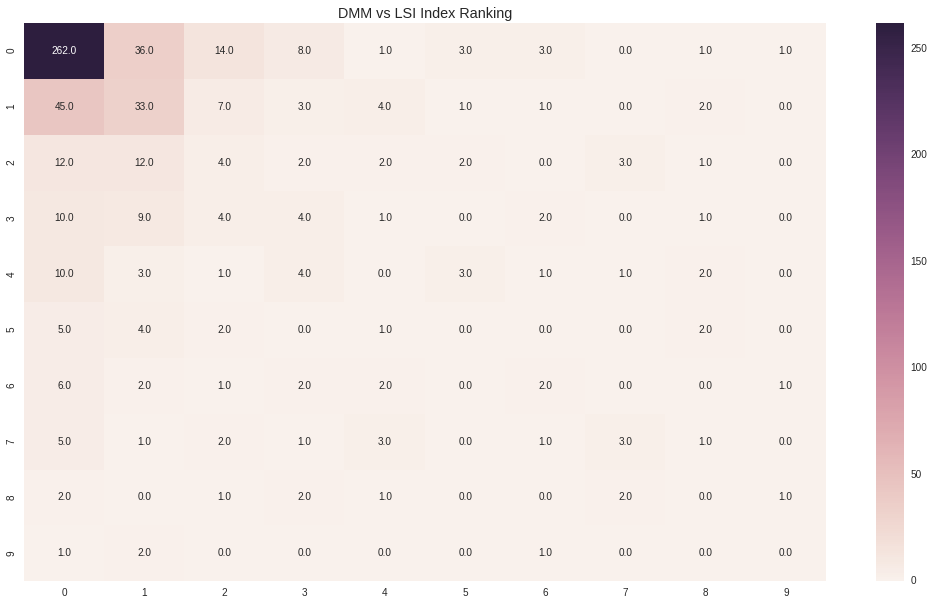

In [59]:
slice_noinferred = get_vec(dmm, ' '.join(slice_doc))
new_vec = dictionary.doc2bow(slice_doc)
new_vec_ls = lsi[new_vec]plt.figure(figsize=(16, 10))
plt.title('DMM vs LSI Index Ranking')
sns.heatmap(dlm_pivot.as_matrix()[:10,:10], annot=True, fmt='')
plt.show()

In [132]:
# new_doc = ' '.join(slice_docs[200])
new_doc = u"Được biết Viettel đã và đang tăng nhanh vùng phủ_sóng G tới hơn diện_tích tỉnh thành_phố trong năm Nhiều ưu_đãi cho người dùng USB G của Viettel Tôi Viết TNO Từ ngày đến hết ngày người_dùng khi đăng_ký sử_dụng dịch_vụ USB G của Viettel sẽ được hưởng nhiều chính_sách ưu_đãi Để biết thêm thông_tin chi_tiết bạn_đọc có thể tham_khảo thêm tại website g vietteltele Nếu người_dùng mua USB G và hòa_mạng trả trước sẽ được tặng MB lưu_lượng sử_dụng kể từ tháng thứ phải kích_hoạt liên_tục trong tháng Cụ thể người_dùng khi mua USB G giá đồng và sử_dụng dịch_vụ hòa_mạng trả sau sẽ được miễn phí hòa_mạng trị_giá đồng tặng đồng cước sử_dụng bao_gồm cước thuê_bao và cước lưu_lượng số tiền này được giảm trừ đồng tháng vào cước sử_dụng trong tháng liên_tiếp kể từ tháng liền kề tháng hòa mạng."
print new_doc

Được biết Viettel đã và đang tăng nhanh vùng phủ_sóng G tới hơn diện_tích tỉnh thành_phố trong năm Nhiều ưu_đãi cho người dùng USB G của Viettel Tôi Viết TNO Từ ngày đến hết ngày người_dùng khi đăng_ký sử_dụng dịch_vụ USB G của Viettel sẽ được hưởng nhiều chính_sách ưu_đãi Để biết thêm thông_tin chi_tiết bạn_đọc có thể tham_khảo thêm tại website g vietteltele Nếu người_dùng mua USB G và hòa_mạng trả trước sẽ được tặng MB lưu_lượng sử_dụng kể từ tháng thứ phải kích_hoạt liên_tục trong tháng Cụ thể người_dùng khi mua USB G giá đồng và sử_dụng dịch_vụ hòa_mạng trả sau sẽ được miễn phí hòa_mạng trị_giá đồng tặng đồng cước sử_dụng bao_gồm cước thuê_bao và cước lưu_lượng số tiền này được giảm trừ đồng tháng vào cước sử_dụng trong tháng liên_tiếp kể từ tháng liền kề tháng hòa mạng.


In [133]:
slice_inferred = dmm.infer_vector(slice_doc)
new_vec = dictionary.doc2bow(slice_doc)
new_vec_ls = lsi[new_vec]

In [134]:
print sorted(new_vec_ls, key=lambda x: x[1], reverse=True)[:10]
print 
print lsi.print_topic(1, topn=20)
print
print lsi.print_topic(5, topn=20)
print
print lsi.print_topic(0, topn=20)

[(1, 6.123455254381911), (5, 4.2726596359602818), (0, 3.0928358370909632), (11, 1.6450306390305525), (16, 1.4555267221445902), (58, 1.2479026358477452), (134, 1.231797534870489), (10, 1.1596437853171246), (21, 1.1290188758126527), (149, 1.1175044399000842)]

0.271*"em" + 0.253*"mình" + 0.250*"bạn" + -0.205*"công_ty" + -0.175*"doanh_nghiệp" + 0.170*"thảo_luận" + 0.158*"anh" + 0.155*"tôi" + 0.152*"nó" + 0.144*"người" + 0.136*"bác" + 0.126*"nói" + -0.121*"dịch_vụ" + 0.119*"một" + -0.116*"phát_triển" + -0.114*"hoạt_động" + 0.113*"nào" + 0.110*"ko" + -0.107*"trong" + 0.106*"còn"

-0.352*"một" + 0.266*"em" + 0.263*"thảo_luận" + 0.210*"bác" + -0.194*"tôi" + -0.177*"người" + -0.166*"khách_hàng" + -0.155*"anh" + -0.153*"công_ty" + 0.153*"doanh_nghiệp" + 0.145*"ko" + 0.139*"đầu_tư" + 0.131*"viettel" + -0.129*"sản_phẩm" + -0.127*"chuyên_đề" + -0.126*"thể" + 0.120*"viễn_thông" + -0.119*"đề_tài" + -0.113*"cô" + 0.112*"đồng"

0.415*"trong" + 0.241*"một" + 0.229*"về" + 0.187*"đến" + 0.162*"việt_nam" 

In [135]:
topics = [1,5,0]
keywords = defaultdict(int)
for topic in topics:
    for v, k in sorted(lsi.show_topic(topic, topn=20), key=lambda x: x[0], reverse=True):
        keywords[k] += v

In [136]:
keywords_sorted = sorted(keywords.iteritems(),key=lambda x: x[1], reverse=True)
for k,v in keywords_sorted:
    print k, v

em 0.536498841764
thảo_luận 0.43350039261
mình 0.347286091603
bác 0.345801839276
trong 0.308140112129
ko 0.255462967373
bạn 0.249565189119
viettel 0.247503635595
về 0.22880150793
còn 0.224299382702
đến 0.187287408415
việt_nam 0.161721027582
nó 0.152438251042
đầu_tư 0.138914649203
doanh_nghiệp 0.127202067799
nói 0.126230160243
viễn_thông 0.120038431691
nào 0.11337477723
đồng 0.112150858791
hơn 0.111424654983
người 0.104278178649
thị_trường 0.0986109404525
mới 0.0917063178819
dịch_vụ 0.0248679217659
thể 0.00994429187864
một 0.00725447762636
anh 0.00272320692612
phát_triển -0.0181414072845
hoạt_động -0.0186206986743
sản_phẩm -0.0345433206813
tôi -0.0395223368643
khách_hàng -0.0398575527657
cô -0.112888483583
đề_tài -0.118808111422
chuyên_đề -0.127032361264
công_ty -0.202165270849


In [138]:
for k, v in dmm.docvecs.most_similar([slice_inferred]):
    print k,v

SENT_vt_179623 0.810759365559
SENT_vt_168283 0.775252401829
SENT_vt_91756 0.698456704617
SENT_vt_108715 0.693614065647
SENT_vt_155419 0.687367320061
SENT_vt_119876 0.685955166817
SENT_vt_76776 0.685797333717
SENT_vt_145977 0.684691429138
SENT_vt_132311 0.681233644485
SENT_vt_61658 0.679900467396


In [123]:
df["Doc"] = [' '.join(doc) for doc in slice_docs]

In [124]:
df.head()

,Len,DMM,SUM,LSI,Doc
DocID,,,,,
24,60,21,28419,0,dành_cho sim_viettel đăng_ký mới gói_cước fami...
147,50,44,13374,0,mạng cung_cấp dịch_vụ thông_tin di_động công_t...
235,186,8,301,13,tiêu_thụ tốt hiện thị_trường chủ_yếu bán dòng ...
269,14,47,537,0,thẻ bấm ok nạp_tiền cách_thứ nạp_tiền thuê_bao...
328,22,6438,5224,3,gần_nhau đại_diện clb borussia_dortmund đánh_g...


In [99]:
df.to_json("/home/laampt/nlp/data/news/vt_1Kdocs_random_pd.json")

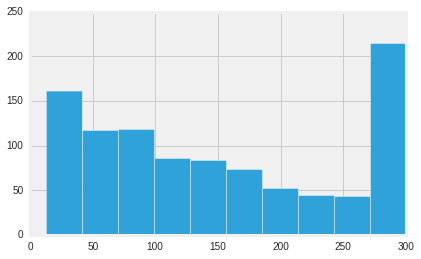

In [100]:
df.Len.hist()

In [141]:
df[df.Len == df.Len.max()].describe()

,Len,DMM,SUM,LSI
count,74,74.000000,74.000000,74.000000
mean,500,5.783784,1652.378378,4.283784
std,0,12.717446,5035.807396,10.173186
min,500,0.000000,0.000000,0.000000
25%,500,0.000000,16.250000,0.000000
50%,500,1.000000,71.000000,0.000000
75%,500,2.750000,261.000000,3.750000
max,500,57.000000,30814.000000,61.000000
